In [1]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web

pd.options.display.float_format = "{:,.3f}".format
import datetime
from datetime import date

import seaborn as sns
from IPython.display import VimeoVideo
from matplotlib import pyplot as plt

In [2]:
# start = datetime.date.today()-datetime.timedelta(365*10)
# end = datetime.date.today()
start = datetime.date(2011, 11, 25)
end = datetime.date(2021, 11, 22)

prices = web.DataReader(["^GSPC", "^RUT"], "yahoo", start, end)["Adj Close"]

# Rename column to make names more intuitive
prices = prices.rename(columns={"^GSPC": "SP500", "^RUT": "Russell2000"})

In [3]:
prices.describe()

Symbols,SP500,Russell2000
count,"2,515.000","2,515.000"
mean,"2,436.210","1,352.007"
std,802.765,384.850
min,"1,158.670",666.160
25%,"1,881.550","1,114.755"
50%,"2,198.180","1,264.300"
75%,"2,876.725","1,552.530"
max,"4,704.540","2,442.740"


In [4]:
prices.head()

Symbols,SP500,Russell2000
Date,,
2011-11-25,"1,158.670",666.160
2011-11-28,"1,192.550",697.900
2011-11-29,"1,195.190",696.100
2011-11-30,"1,246.960",737.420
2011-12-01,"1,244.580",730.750


### 1.2 Calculate log returns, remove unused columns, and drop nulls


In [5]:
df = np.log(prices) - np.log(prices.shift(1))
df = df.iloc[1:, 0:]

In [6]:
df.head()

Symbols,SP500,Russell2000
Date,,
2011-11-28,0.029,0.047
2011-11-29,0.002,-0.003
2011-11-30,0.042,0.058
2011-12-01,-0.002,-0.009
2011-12-02,-0.000,0.006


### 1.3 Calculating Future Value of each Index


In [7]:
df.mean() * 100

Symbols
SP500         0.056
Russell2000   0.050
dtype: float64

In [8]:
(1 + df.mean()) ** (252 * 10) * 1000

Symbols
SP500         4,053.569
Russell2000   3,509.066
dtype: float64

### 2.1 Price Volatility: High-Low


In [9]:
prices.max()

Symbols
SP500         4,704.540
Russell2000   2,442.740
dtype: float64

In [10]:
prices.min()

Symbols
SP500         1,158.670
Russell2000     666.160
dtype: float64

In [11]:
prices.max() - prices.min()

Symbols
SP500         3,545.870
Russell2000   1,776.580
dtype: float64

In [12]:
currYear = prices.loc[
    date.today() - datetime.timedelta(365) : date.today()  # noqa E203
]
currYear.max() - currYear.min()

Symbols
SP500         159.640
Russell2000   190.250
dtype: float64

In [13]:
(currYear.max() - currYear.min()) / prices.iloc[-1]

Symbols
SP500         0.034
Russell2000   0.082
dtype: float64

### 2.2 Moving Averages 
#### 2.2.1 50-Day Moving Average

<AxesSubplot:xlabel='Date', ylabel='SP500'>

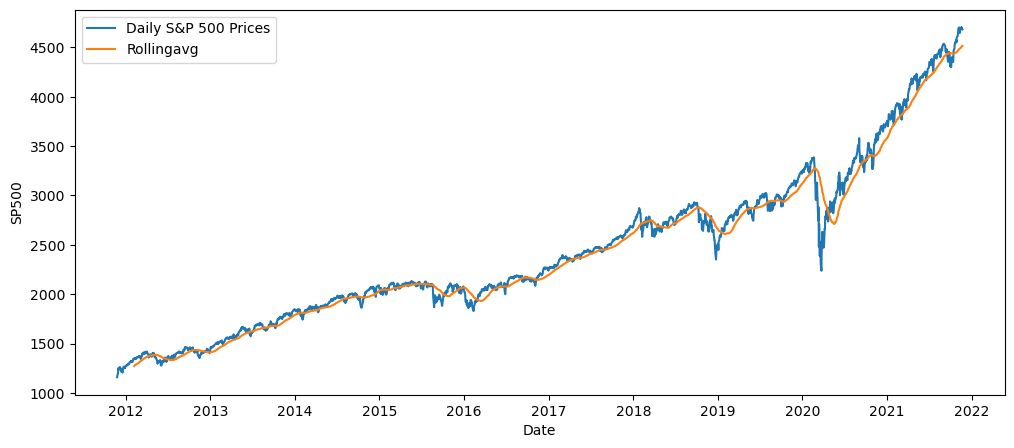

In [14]:
prices["SP500 50 day_rolling_avg"] = prices.SP500.rolling(50).mean()

# set figure size
plt.figure(figsize=(12, 5))

# plot a simple time series plot
# using seaborn.lineplot()
sns.lineplot(x="Date", y="SP500", data=prices, label="Daily S&P 500 Prices")


# plot using rolling average
sns.lineplot(x="Date", y="SP500 50 day_rolling_avg", data=prices, label="Rollingavg")

#### 2.2.2 50-Day Rolling Distance 


In [15]:
((abs(prices - prices.rolling(50).mean())) / prices).mean()

Symbols
SP500                      0.027
Russell2000                0.035
SP500 50 day_rolling_avg   0.020
dtype: float64

### 2.3 Price Volatility: Standard Deviations


In [16]:
prices.std()

Symbols
SP500                      802.765
Russell2000                384.850
SP500 50 day_rolling_avg   769.487
dtype: float64

In [17]:
df.std()

Symbols
SP500         0.010
Russell2000   0.013
dtype: float64

### 2.4 Writing a Comparison Function in Python


In [18]:
def investCompare(startTime, endTime, tickers):
    # pull price data from yahoo -- (list(tickers.keys())) = ['^GSPC','^RUT']
    prices = web.DataReader(list(tickers.keys()), "yahoo", startTime, endTime)[
        "Adj Close"
    ]
    prices = prices.rename(columns=tickers)
    returns = np.log(prices) - np.log(prices.shift(1))
    returns = returns.iloc[1:, 0:]

    # pull data into separate DataFrame, 52weeks to just look at the last 365 days of data for calculating our high/low metric
    currYear = prices.loc[
        date.today() - datetime.timedelta(365) : date.today()  # noqa E203
    ]
    highLow = (currYear.max() - currYear.min()) / prices.iloc[-1]
    highLow = pd.DataFrame(highLow, columns=["HighMinusLow"])

    # Moving average volatility
    MA = pd.DataFrame(
        ((abs(prices - prices.rolling(50).mean())) / prices).mean(),
        columns=["MovingAverageVolatility"],
    )

    investments = pd.merge(highLow, MA, on="Symbols")
    investments = pd.merge(
        investments,
        pd.DataFrame(returns.std(), columns=["StandardDeviation"]),
        on="Symbols",
    )
    investments = pd.merge(
        investments,
        pd.DataFrame(100 * returns.mean(), columns=["Daily Return Percentage"]),
        on="Symbols",
    )

    return investments.round(3)

In [19]:
investCompare(
    datetime.date(2020, 1, 1),
    datetime.date.today(),
    {"^GSPC": "SP500", "^RUT": "Russell2000"},
)

C:\Users\25472\anaconda3\envs\base2\lib\site-packages\pandas_datareader\base.py:272: SymbolWarning: Failed to read symbol: '^RUT', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)


,HighMinusLow,MovingAverageVolatility,StandardDeviation,Daily Return Percentage
Symbols,,,,
SP500,0.325,0.042,0.016,0.020
Russell2000,NaN,NaN,NaN,NaN


In [20]:
investCompare(
    datetime.date(2020, 1, 1),
    datetime.date.today(),
    {"^GSPC": "SP500", "^RUT": "Russell2000", "AAPL": "Apple"},
)

C:\Users\25472\anaconda3\envs\base2\lib\site-packages\pandas_datareader\base.py:272: SymbolWarning: Failed to read symbol: '^GSPC', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)
C:\Users\25472\anaconda3\envs\base2\lib\site-packages\pandas_datareader\base.py:272: SymbolWarning: Failed to read symbol: '^RUT', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)


,HighMinusLow,MovingAverageVolatility,StandardDeviation,Daily Return Percentage
Symbols,,,,
Apple,0.349,0.067,0.023,0.098
SP500,NaN,NaN,NaN,NaN
Russell2000,NaN,NaN,NaN,NaN


## 2.6 Comparing Growth vs. Value stocks


In [21]:
investCompare(
    datetime.date(2020, 1, 1), datetime.date.today(), {"VUG": "Growth", "VTV": "Value"}
)

,HighMinusLow,MovingAverageVolatility,StandardDeviation,Daily Return Percentage
Symbols,,,,
Growth,0.524,0.054,0.019,0.027
Value,0.193,0.036,0.016,0.022


In [22]:
investCompare(
    datetime.date(2010, 1, 1), datetime.date.today(), {"VUG": "Growth", "VTV": "Value"}
)

C:\Users\25472\anaconda3\envs\base2\lib\site-packages\pandas_datareader\base.py:272: SymbolWarning: Failed to read symbol: 'VTV', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)


,HighMinusLow,MovingAverageVolatility,StandardDeviation,Daily Return Percentage
Symbols,,,,
Growth,0.524,0.034,0.012,0.048
Value,NaN,NaN,NaN,NaN


## 2.7 Comparing Domestic vs. Foreign Stocks


In [23]:
investCompare(
    datetime.date(2020, 1, 1),
    datetime.date.today(),
    {"^GSPC": "SP500", "SPEU": "Europe ETF", "GXC": "China ETF"},
)

C:\Users\25472\anaconda3\envs\base2\lib\site-packages\pandas_datareader\base.py:272: SymbolWarning: Failed to read symbol: '^GSPC', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)


,HighMinusLow,MovingAverageVolatility,StandardDeviation,Daily Return Percentage
Symbols,,,,
Europe ETF,0.457,0.045,0.016,-0.016
China ETF,0.734,0.054,0.019,-0.059
SP500,NaN,NaN,NaN,NaN


In [24]:
investCompare(
    datetime.date(2010, 1, 1),
    datetime.date.today(),
    {"^GSPC": "SP500", "SPEU": "Europe ETF", "GXC": "China ETF"},
)

,HighMinusLow,MovingAverageVolatility,StandardDeviation,Daily Return Percentage
Symbols,,,,
SP500,0.325,0.029,0.011,0.037
Europe ETF,0.457,0.033,0.013,0.008
China ETF,0.734,0.045,0.016,0.005
